In [111]:
# -*- coding: utf-8 -*-
import dataiku
import pandas as pd, numpy as np
from dataiku import pandasutils as pdu

from datetime import date, datetime, timedelta
import time

import matplotlib.pyplot as plt
pd.options.display.float_format = '{:,}'.format

t0 = time.time()

# Read recipe inputs
NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2019 = dataiku.Dataset("NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2019")
NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2019_df = NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2019.get_dataframe()
print('loaded file 2019')

NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2021 = dataiku.Dataset("NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2021")
NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2021_df = NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2021.get_dataframe()
print('loaded file 2020')

NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2020 = dataiku.Dataset("NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2020")
NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2020_df = NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2020.get_dataframe()
print('loaded file 2021')

NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2022 = dataiku.Dataset("NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2022")
NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2022_df = NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2022.get_dataframe()
print('loaded file 2022')

NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT = dataiku.Dataset("NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT")
NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT_df = NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT.get_dataframe()
print('loaded annual card count')

HFM_cost_by_MRU = dataiku.Dataset("HFM_cost_by_MRU")
HFM_cost_by_MRU_df = HFM_cost_by_MRU.get_dataframe()
print('loaded HFM cost data')

t1 = time.time()
print("load duration", (t1-t0)/60.0, "minutes")

# Compute recipe outputs
# TODO: Write here your actual code that computes the outputs
# NB: DSS supports several kinds of APIs for reading and writing data. Please see doc.

loaded file 2019
loaded file 2020
loaded file 2021


/data/dataiku/dss_data/code-envs/python/env_clc/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


loaded file 2022
loaded annual card count
loaded HFM cost data
load duration 11.490816330909729 minutes


In [112]:
row_count = 0
row_count += len(NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2019_df)
row_count += len(NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2020_df)
row_count += len(NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2021_df)
row_count += len(NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2022_df)
print(row_count)

df = pd.concat([NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2019_df, NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2020_df,
               NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2021_df, NAFCUSTOMER_REVENUE_AGGREGATED_MRU_2022_df])

print(len(df), "NAFCUSTOMER REVENUE AGGREGATED")

print(len(NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT_df), "NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT_df")
df_a = NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT_df

19405984
19405984 NAFCUSTOMER REVENUE AGGREGATED
2319568 NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT_df


In [113]:
df['CUSTOMER_ID'] = df['CUSTOMER_ID'].astype('Int64')
df['SETUP_DATE_DT'] = pd.to_datetime(df['SETUP_DATE'])
df['SETUP_YEAR'] = df.SETUP_DATE_DT.dt.year

df['REVENUE_YEAR'] = df['REVENUE_YEAR'].astype('Int64')
df['REVENUE_DATE'] = df['REVENUE_MONTH'].astype(str) + '-' + df['REVENUE_YEAR'].astype(str)
df['REVENUE_DATE'] = pd.to_datetime(df['REVENUE_DATE'], format='%m-%Y').dt.strftime('%m-%Y')

df['MRU'] = df.BI_MRU
df.loc[df.MRU.isnull(),'MRU'] = 3100
df.loc[df.MRU=='TBD','MRU'] = 3100
df['MRU'] = df['MRU'].astype(float)
df['MRU'] = df['MRU'].astype('Int64')
df.MRU.value_counts()

print(len(df), "before filter")
df = df[df.REVENUE_YEAR!=2023]
print(len(df), "after filter, removing 2023")

# break down of revenue_year
df.REVENUE_YEAR.value_counts()

df.head()

19405984 before filter
19405984 after filter, removing 2023


,CUSTOMER_ID,CUSTOMER,REVENUE_YEAR,REVENUE_MONTH,CUSTOMER_BUSINESS_PROGRAM_NAME,BI_CUS_PAR,BI_PRODUCT,BI_MRU,SETUP_DATE,REVENUE_AMOUNT_USD,GROSS_SPEND_AMOUNT,PURCHASE_GALLONS_QTY,TOTAL_ACTIVE_CARD_COUNT,SETUP_DATE_DT,SETUP_YEAR,REVENUE_DATE,MRU
0,77553684,STATE OF IOWA,2019,11,Wright Express Fleet Universal,"51,000.0","10,100.0","3,100.0",2013-08-19 07:00:00+00:00,"22,705.96","1,450,884.46","563,755.553","6,505.0",2013-08-19 07:00:00+00:00,2013,11-2019,3100
1,77214249,EVANGELISTO CONSTRUCTION LLC,2019,1,Sunoco Universal,"51,200.0","15,308.0","4,120.0",2018-08-30 07:00:00+00:00,23.15,652.98,297.782,4.0,2018-08-30 07:00:00+00:00,2018,01-2019,4120
2,77434788,OLIVER SERVICES LLC,2019,12,Chevron and Texaco Business Access,"11,200.0","15,308.0","4,000.0",2018-04-11 07:00:00+00:00,68.83,303.8,105.42299999999999,1.0,2018-04-11 07:00:00+00:00,2018,12-2019,4000
3,77540790,SOI AVIATION INC,2019,3,Chevron and Texaco Business,"11,200.0","15,100.0","4,000.0",2018-12-03 08:00:00+00:00,85.0,111.44,29.159000000000002,1.0,2018-12-03 08:00:00+00:00,2018,03-2019,4000
4,77381882,MASCO CANADA LTD,2019,5,Esso Business Premier Plus,"20,800.0","15,100.0","4,000.0",2014-11-03 08:00:00+00:00,76.46,"8,498.36","2,102.5557",25.0,2014-11-03 08:00:00+00:00,2014,05-2019,4000


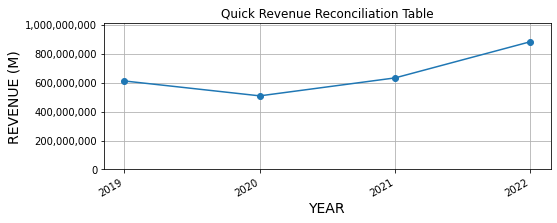

,REVENUE_YEAR,REVENUE_AMOUNT_USD
0,2019,"611,886,393.7099723"
1,2020,"508,936,503.09999055"
2,2021,"633,153,608.6199423"
3,2022,"883,294,206.3301082"


In [114]:
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

# plot out sum of revenue per year
# in order to do a quick reonciliation against

# aggregate revenue at annual grain
df_revenue_per_year = df.groupby(['REVENUE_YEAR']).REVENUE_AMOUNT_USD.sum().reset_index()
df_revenue_per_year.REVENUE_AMOUNT_USD = df_revenue_per_year.REVENUE_AMOUNT_USD
df_revenue_per_year.head()

max_revenue = df_revenue_per_year.REVENUE_AMOUNT_USD.max()

chart_revenue_year = []
for y in df_revenue_per_year.REVENUE_YEAR.tolist():
    chart_revenue_year.append(str(y))

fig, ax1 = plt.subplots(figsize=(8,3))
ax1.plot(chart_revenue_year,df_revenue_per_year['REVENUE_AMOUNT_USD'], marker='o')
ax1.set_xlabel('YEAR', fontsize=14)
ax1.set_ylabel('REVENUE (M)', fontsize=14)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.grid()
ax1.set_ylim(ymin=0, ymax=max_revenue*1.15)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
fig.autofmt_xdate()
plt.title('Quick Revenue Reconciliation Table')
plt.show()

df_revenue_per_year.head()

In [0]:
df_customer_MRU = df.groupby(['CUSTOMER_ID','CUSTOMER']).MRU.min().reset_index()
df_customer_program = df.groupby(['CUSTOMER_ID','CUSTOMER']).CUSTOMER_BUSINESS_PROGRAM_NAME.first().reset_index()

df_customer_revenue_by_year = df.groupby(['CUSTOMER_ID','CUSTOMER','REVENUE_YEAR']).REVENUE_AMOUNT_USD.sum().reset_index()
print(len(df_customer_revenue_by_year))

df_active_card_count_by_customer = df_a.groupby(['CUSTOMER_ID','CUSTOMER','YEAR_NUMBER']).ACTIVE_CARD_COUNT.sum().reset_index()
df_active_card_count_by_customer.columns = ['CUSTOMER_ID','CUSTOMER','REVENUE_YEAR','ACTIVE_CARD_COUNT']
df_active_card_count_by_customer.head()

df_x = pd.merge(df_customer_revenue_by_year,df_active_card_count_by_customer, how='left', on=['CUSTOMER_ID','CUSTOMER','REVENUE_YEAR'])
print(len(df_x))

df_customer_fleet_size = df_active_card_count_by_customer.groupby(['CUSTOMER_ID','CUSTOMER']).ACTIVE_CARD_COUNT.max().reset_index()
df_customer_fleet_size.columns = ['CUSTOMER_ID', 'CUSTOMER', 'FLEET_SIZE']

df_x = pd.merge(df_x, df_customer_fleet_size, how='left', on=['CUSTOMER_ID','CUSTOMER'])
print(len(df_x))

df_x = pd.merge(df_x, df_customer_MRU, how='left', on=['CUSTOMER_ID','CUSTOMER'])
print(len(df_x))

df_x = pd.merge(df_x, df_customer_program, how='left', on=['CUSTOMER_ID','CUSTOMER'])
print(len(df_x))

df_x.loc[df_x.CUSTOMER_BUSINESS_PROGRAM_NAME=='WEX Universal','MRU'] = 4120
df_x.head()

In [116]:
revenue_by_MRU = df_x.groupby(['MRU','REVENUE_YEAR']).REVENUE_AMOUNT_USD.sum().reset_index()
revenue_by_MRU[revenue_by_MRU.REVENUE_YEAR.isin([2020,2021])]

,MRU,REVENUE_YEAR,REVENUE_AMOUNT_USD
1,3100,2020,"111,649,921.17165461"
2,3100,2021,"135,525,245.3410088"
5,4000,2020,"118,696,172.50555496"
6,4000,2021,"157,426,655.84217083"
9,4120,2020,"278,590,947.1227956"
10,4120,2021,"340,196,333.1168244"


In [117]:
revenue_by_MRU = df_x.groupby(['MRU','REVENUE_YEAR']).ACTIVE_CARD_COUNT.sum().reset_index()
revenue_by_MRU[revenue_by_MRU.REVENUE_YEAR.isin([2020,2021])]

,MRU,REVENUE_YEAR,ACTIVE_CARD_COUNT
1,3100,2020,"3,645,369.0"
2,3100,2021,"3,720,990.0"
5,4000,2020,"2,194,730.0"
6,4000,2021,"2,547,874.0"
9,4120,2020,"2,268,161.0"
10,4120,2021,"2,522,808.0"


In [0]:
# create dataset by year,customer,business program, mru
# join in customer fleet size
# render revenue by MRU for 2020
# render revenue by MRU for 2021
# find the fleet size threshold that will move customers in oder to right size the revenue amounts
# summarize the counts

#df_active_card_count_by_customer = df_a.groupby(['CUSTOMER_ID','CUSTOMER','YEAR_NUMBER']).ACTIVE_CARD_COUNT.sum().reset_index()
#df_active_card_count_by_customer.columns = ['CUSTOMER_ID','CUSTOMER','REVENUE_YEAR','ACTIVE_CARD_COUNT']
#print(len(df_active_card_count_by_customer))

#df_customer_fleet_size = df_active_card_count_by_customer.groupby(['CUSTOMER_ID','CUSTOMER']).ACTIVE_CARD_COUNT.max().reset_index()
#df_customer_fleet_size.columns = ['CUSTOMER_ID', 'CUSTOMER', 'FLEET_SIZE']

#df_active_card_count_by_customer = pd.merge(df_active_card_count_by_customer,df_customer_fleet_size, on=['CUSTOMER_ID','CUSTOMER'], how='left')
#print(len(df_active_card_count_by_customer))

#df_customer_program = pd.merge(df_customer_program,df_active_card_count_by_customer, how='left', on=['CUSTOMER_ID','CUSTOMER','REVENUE_YEAR'])
#print(len(df_customer_program))
#df_customer_program.head()

In [0]:
print(len(df_active_card_count_by_customer))
df_active_card_count_by_customer.drop_duplicates(subset=['CUSTOMER_ID'], inplace=True)
print(len(df_active_card_count_by_customer))

In [0]:
#COST_BY_SEGMENT_df = ... # Compute a Pandas dataframe to write into COST_BY_SEGMENT

# Write recipe outputs
#COST_BY_SEGMENT = dataiku.Dataset("COST_BY_SEGMENT")
#COST_BY_SEGMENT.write_with_schema(COST_BY_SEGMENT_df)